## Importing the relevant libraries

In [ ]:
!pip install scikit-learn-intelex
!pip install catboost
!pip install feature-engine
!pip install tensorflow
!pip install lightgbm xgboost
!pip install imbalanced-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.5/111.5 MB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 230.0/230.0 kB 4.9 MB/s eta 0:00:00


In [ ]:
import re
import numpy as np
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
%matplotlib inline
import warnings, gc
warnings.filterwarnings('ignore')
from sklearnex import patch_sklearn
patch_sklearn()
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score, KFold, GridSearchCV, RepeatedKFold,StratifiedKFold
from joblib import dump
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, AdaBoostClassifier, GradientBoostingClassifier, HistGradientBoostingClassifier, VotingClassifier, ExtraTreesClassifier, StackingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score, hamming_loss
from scipy.stats import probplot
from feature_engine.selection import DropConstantFeatures, DropDuplicateFeatures, DropCorrelatedFeatures
from imblearn.over_sampling import BorderlineSMOTE, RandomOverSampler
from collections import Counter
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, SelectPercentile, SelectFromModel, f_classif
from subprocess import call
from IPython.display import Image
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

Extension for Scikit-learn* enabled (https://github.com/uxlfoundation/scikit-learn-intelex)


## Loading the dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

df = pd.read_csv('/content/drive/MyDrive/DATN/data/63tinh_hourly.csv')
df.head()

Mounted at /content/drive


,time,temperature_2m (°C),apparent_temperature (°C),dew_point_2m (°C),precipitation (mm),rain (mm),snowfall (cm),snow_depth (m),cloud_cover (%),relative_humidity_2m (%),wind_gusts_10m (km/h),wind_speed_10m (km/h),wind_direction_10m (°),surface_pressure (hPa),pressure_msl (hPa),weather_code (wmo code)
0,2020-01-01T00:00,19.4,21.8,18.2,0.4,0.4,0.0,0.0,100,93,6.8,4.6,219,1022.1,1024.1,51
1,2020-01-01T01:00,19.3,21.6,18.2,0.3,0.3,0.0,0.0,100,93,6.8,4.6,252,1021.9,1023.9,51
2,2020-01-01T02:00,19.2,21.6,18.1,0.1,0.1,0.0,0.0,100,94,6.8,4.0,270,1021.4,1023.4,51
3,2020-01-01T03:00,19.1,21.6,18.1,0.1,0.1,0.0,0.0,100,94,6.1,3.1,306,1021.4,1023.4,51
4,2020-01-01T04:00,18.8,20.9,17.8,0.1,0.1,0.0,0.0,99,94,7.9,5.4,340,1021.3,1023.3,51


In [ ]:
df.shape

(2762424, 16)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2762424 entries, 0 to 2762423
Data columns (total 16 columns):
 #   Column                     Dtype  
---  ------                     -----  
 0   time                       object 
 1   temperature_2m (°C)        float64
 2   apparent_temperature (°C)  float64
 3   dew_point_2m (°C)          float64
 4   precipitation (mm)         float64
 5   rain (mm)                  float64
 6   snowfall (cm)              float64
 7   snow_depth (m)             float64
 8   cloud_cover (%)            int64  
 9   relative_humidity_2m (%)   int64  
 10  wind_gusts_10m (km/h)      float64
 11  wind_speed_10m (km/h)      float64
 12  wind_direction_10m (°)     int64  
 13  surface_pressure (hPa)     float64
 14  pressure_msl (hPa)         float64
 15  weather_code (wmo code)    int64  
dtypes: float64(11), int64(4), object(1)
memory usage: 337.2+ MB


In [ ]:
df.describe()

,temperature_2m (°C),apparent_temperature (°C),dew_point_2m (°C),precipitation (mm),rain (mm),snowfall (cm),snow_depth (m),cloud_cover (%),relative_humidity_2m (%),wind_gusts_10m (km/h),wind_speed_10m (km/h),wind_direction_10m (°),surface_pressure (hPa),pressure_msl (hPa),weather_code (wmo code)
count,2.762424e+06,2.762424e+06,2.762424e+06,2.762424e+06,2.762424e+06,2762424.0,2762424.0,2.762424e+06,2.762424e+06,2.762424e+06,2.762424e+06,2.762424e+06,2.762424e+06,2.762424e+06,2.762424e+06
mean,2.508828e+01,2.869298e+01,2.116888e+01,2.542430e-01,2.542430e-01,0.0,0.0,7.380951e+01,8.046228e+01,2.028618e+01,8.898207e+00,1.622328e+02,9.965531e+02,1.010666e+03,1.709879e+01
std,4.829591e+00,6.730056e+00,4.648546e+00,1.011869e+00,1.011869e+00,0.0,0.0,3.479157e+01,1.458371e+01,1.051993e+01,5.347825e+00,9.684433e+01,3.022085e+01,5.407265e+00,2.353701e+01
min,3.000000e+00,-2.500000e+00,-8.700000e+00,0.000000e+00,0.000000e+00,0.0,0.0,0.000000e+00,1.200000e+01,7.000000e-01,0.000000e+00,0.000000e+00,8.448000e+02,9.558000e+02,0.000000e+00
25%,2.260000e+01,2.510000e+01,1.910000e+01,0.000000e+00,0.000000e+00,0.0,0.0,4.800000e+01,7.200000e+01,1.220000e+01,4.800000e+00,8.700000e+01,9.999000e+02,1.007200e+03,2.000000e+00
50%,2.550000e+01,3.000000e+01,2.270000e+01,0.000000e+00,0.000000e+00,0.0,0.0,9.600000e+01,8.400000e+01,1.870000e+01,7.800000e+00,1.480000e+02,1.007000e+03,1.010100e+03,3.000000e+00
75%,2.820000e+01,3.320000e+01,2.440000e+01,1.000000e-01,1.000000e-01,0.0,0.0,1.000000e+02,9.200000e+01,2.660000e+01,1.200000e+01,2.380000e+02,1.010700e+03,1.013700e+03,5.100000e+01
max,4.290000e+01,4.880000e+01,3.290000e+01,7.790000e+01,7.790000e+01,0.0,0.0,1.000000e+02,1.000000e+02,1.721000e+02,9.100000e+01,3.600000e+02,1.033300e+03,1.035400e+03,6.500000e+01


In [ ]:
df.isna().sum()

,0
time,0
temperature_2m (°C),0
apparent_temperature (°C),0
dew_point_2m (°C),0
precipitation (mm),0
rain (mm),0
snowfall (cm),0
snow_depth (m),0
cloud_cover (%),0
relative_humidity_2m (%),0


In [ ]:
df.columns = (
    df.columns
      .str.replace(r'\s*\(.*?\)', '', regex=True)  # xóa (đơn vị)
      .str.replace('Â', '', regex=False)            # xóa ký tự lỗi
      .str.strip()                                  # xóa space đầu/cuối
)

In [ ]:
df.isna().sum()

,0
time,0
temperature_2m,0
apparent_temperature,0
dew_point_2m,0
precipitation,0
rain,0
snowfall,0
snow_depth,0
cloud_cover,0
relative_humidity_2m,0


In [ ]:
df.duplicated().sum()

np.int64(131544)

## Exploratory Data Analysis

Skewness of temperature_2m: -0.5585658800788756
Kurtosis of temperature_2m: 0.6132743200849693


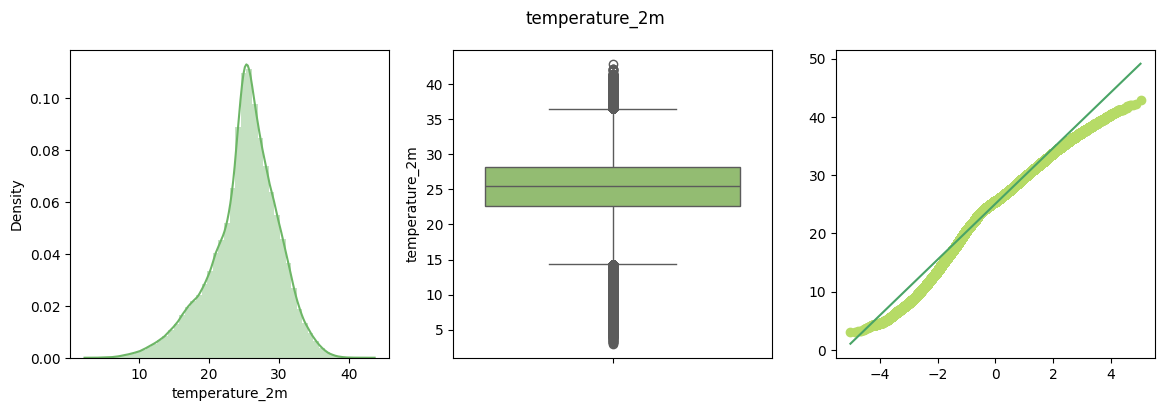

Skewness of apparent_temperature: -0.7892079174857655
Kurtosis of apparent_temperature: 0.5836070458949947


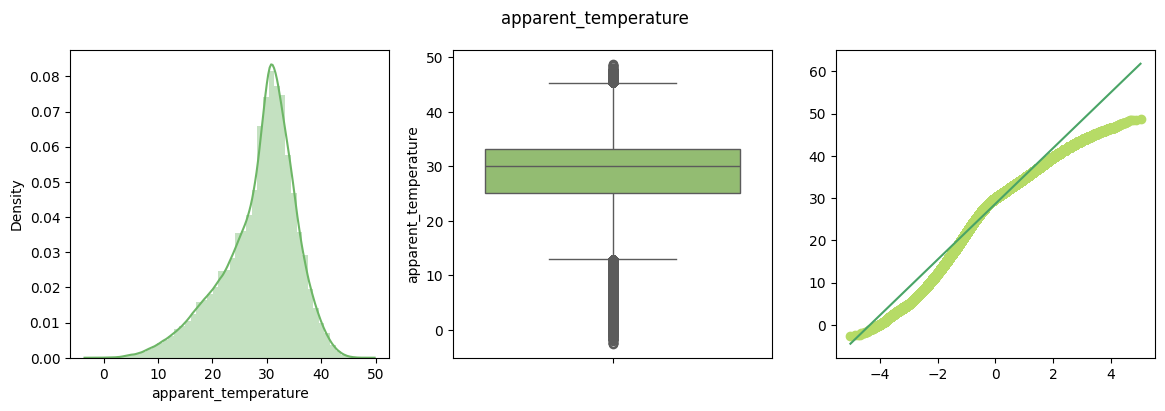

Skewness of dew_point_2m: -1.5189201474835405
Kurtosis of dew_point_2m: 2.5046545949484655


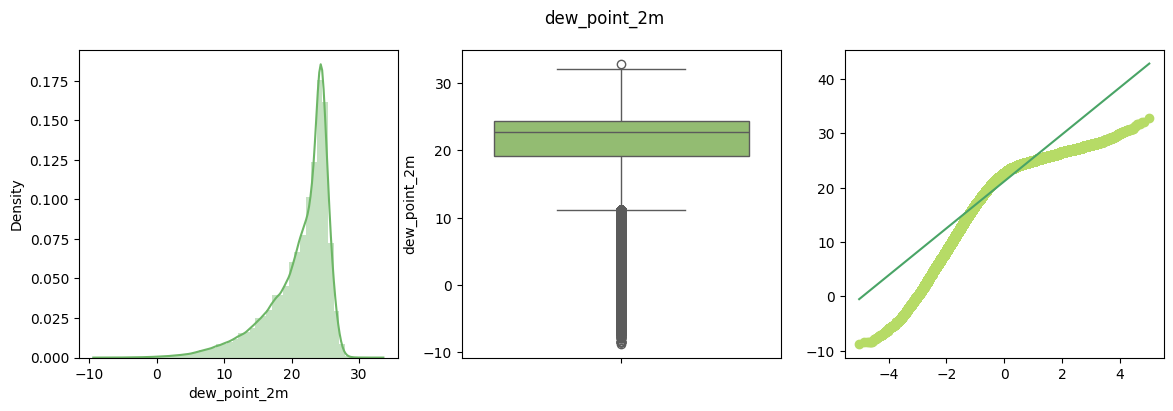

Skewness of precipitation: 10.4024421357668
Kurtosis of precipitation: 218.02959073509714


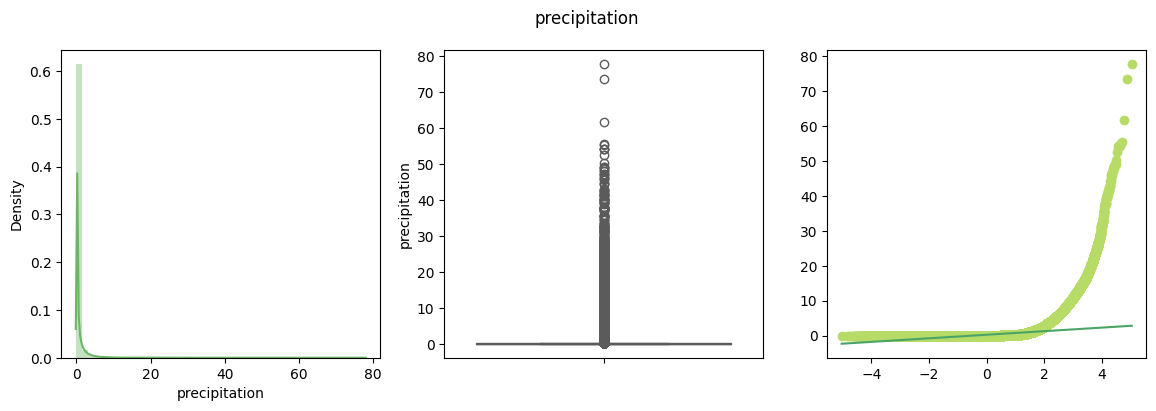

Skewness of rain: 10.4024421357668
Kurtosis of rain: 218.02959073509714


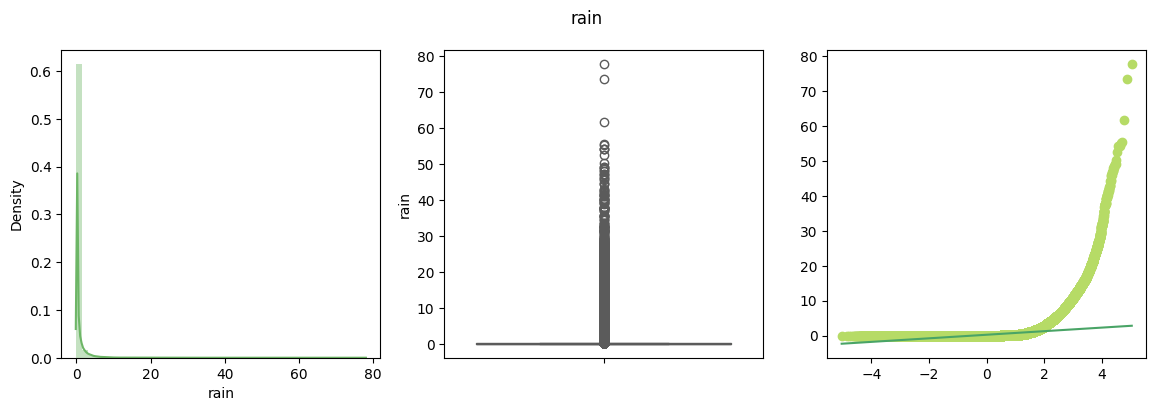

Skewness of snowfall: 0.0
Kurtosis of snowfall: 0.0


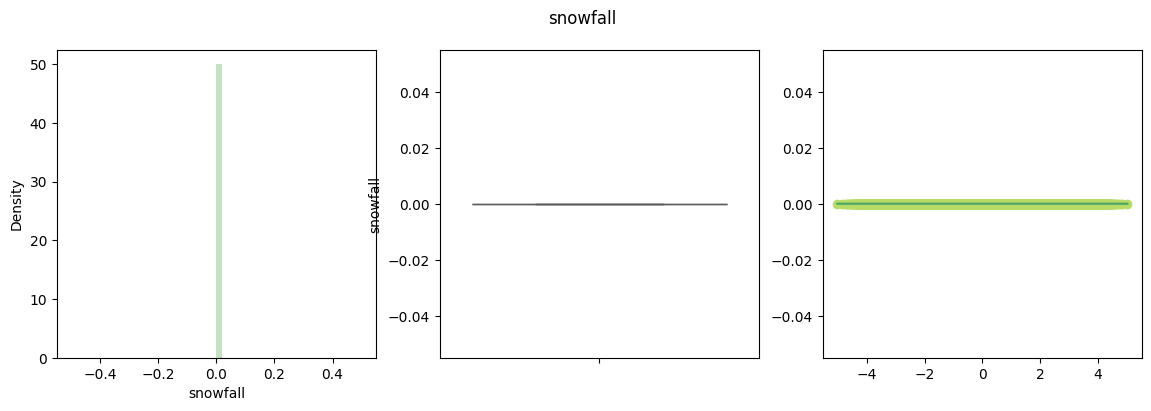

Skewness of snow_depth: 0.0
Kurtosis of snow_depth: 0.0


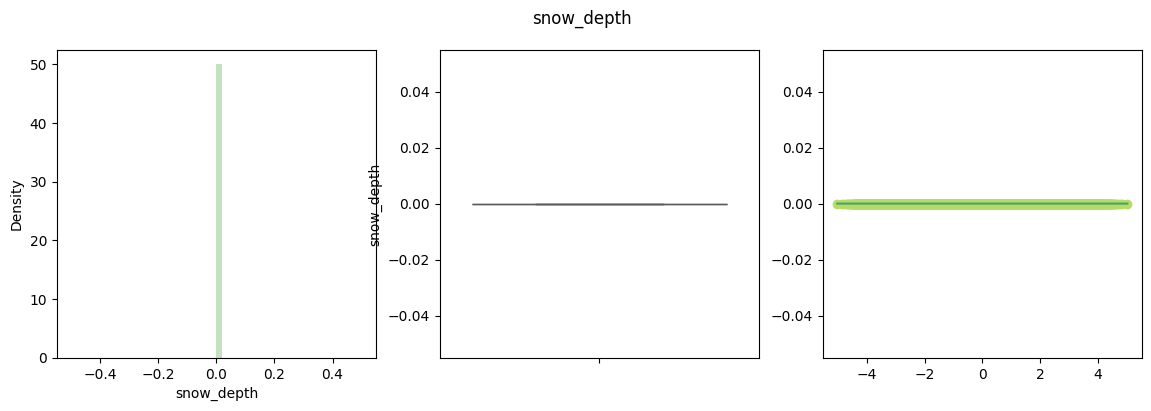

Skewness of cloud_cover: -1.0136205087084629
Kurtosis of cloud_cover: -0.5564890860528613


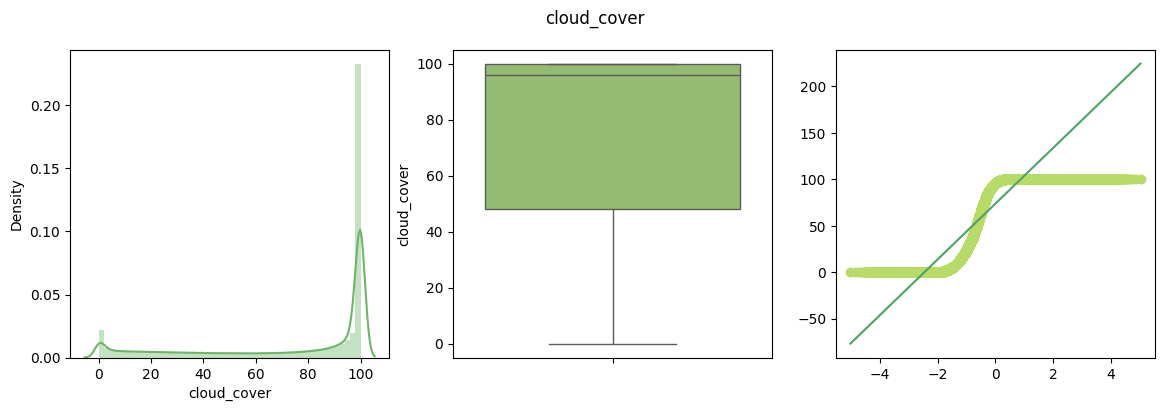

Skewness of relative_humidity_2m: -0.8784224319125138
Kurtosis of relative_humidity_2m: 0.24816439440987637


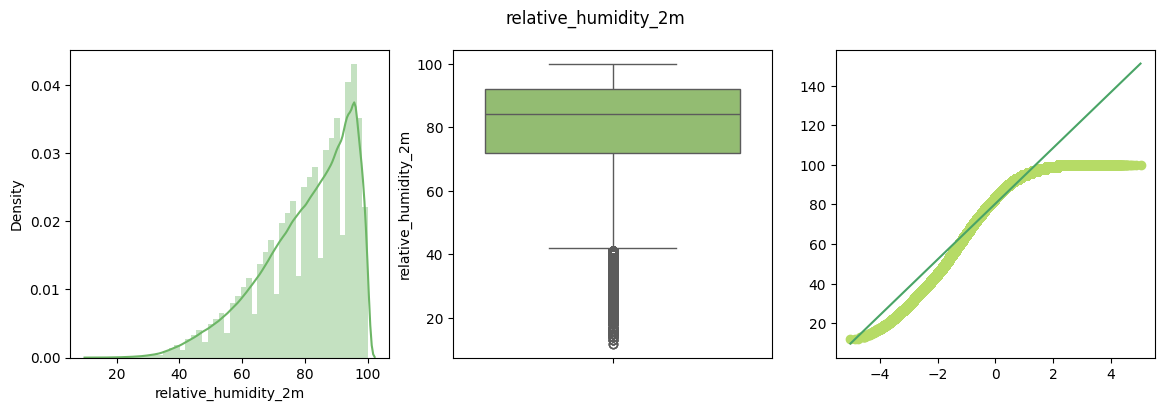

Skewness of wind_gusts_10m: 0.909822551866669
Kurtosis of wind_gusts_10m: 1.191084633574801


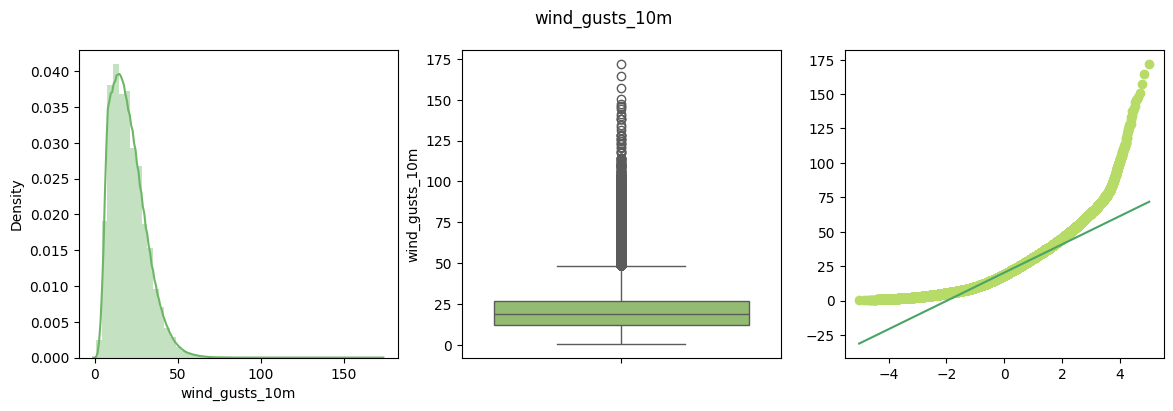

Skewness of wind_speed_10m: 1.0709184637431433
Kurtosis of wind_speed_10m: 1.7103084814793355


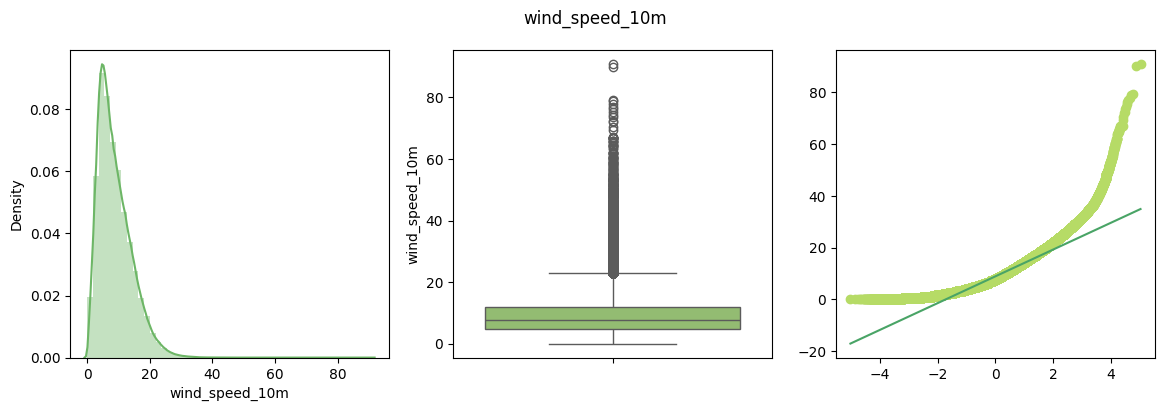

Skewness of wind_direction_10m: 0.329994583169898
Kurtosis of wind_direction_10m: -0.8862456465853841


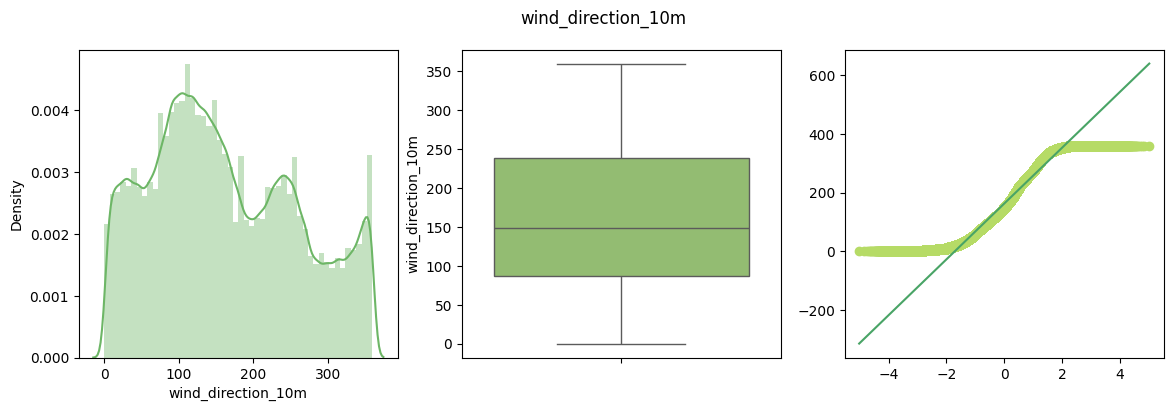

Skewness of surface_pressure: -2.6975421712221004
Kurtosis of surface_pressure: 7.57297583976589


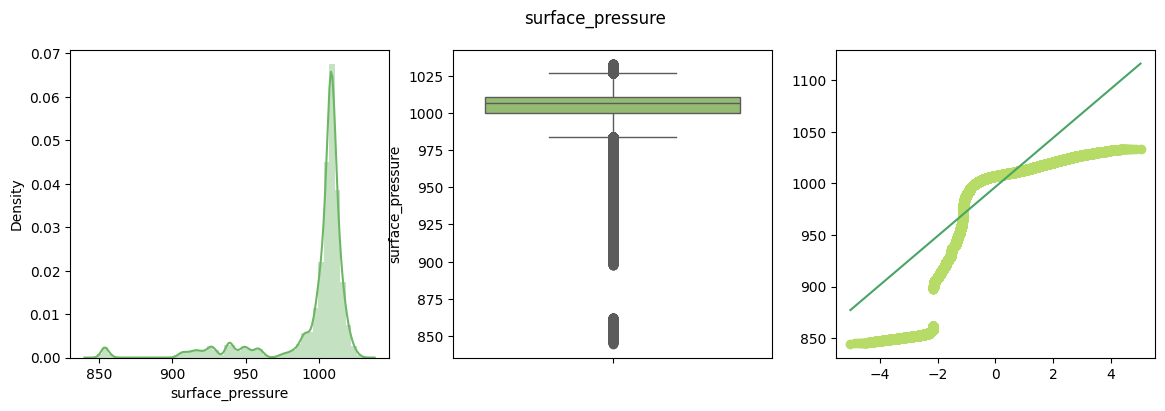

Skewness of pressure_msl: 0.4899724914057906
Kurtosis of pressure_msl: 0.5940105744737285


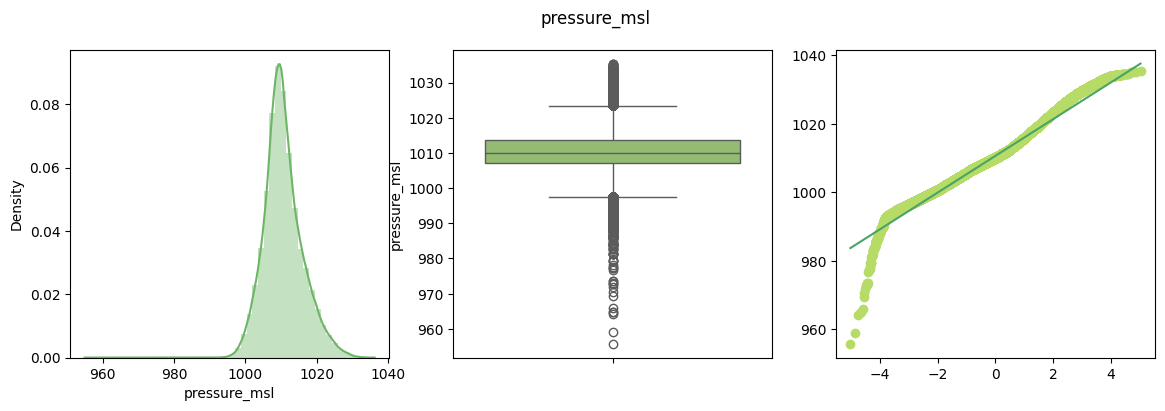

Skewness of weather_code: 0.9368418497520479
Kurtosis of weather_code: -1.056644805620495


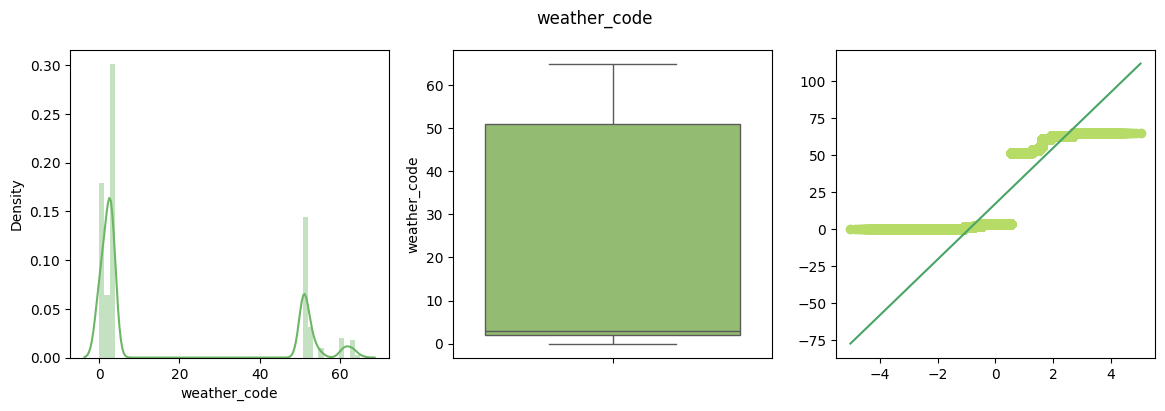

In [ ]:
for col in df.select_dtypes(np.number).columns:
    plt.figure(figsize=(14,4))
    print(f"Skewness of {col}:", df[col].skew())
    print(f"Kurtosis of {col}:", df[col].kurtosis())

    # Biểu đồ phân phối với bảng màu 'summer'
    plt.subplot(131)
    sns.distplot(df[col], color=sns.color_palette("summer")[2])

    # Biểu đồ boxplot với bảng màu 'summer'
    plt.subplot(132)
    sns.boxplot(df[col], color=sns.color_palette("summer")[3])

    # Biểu đồ Q-Q plot với bảng màu 'summer'
    plt.subplot(133)
    osm, osr = probplot(df[col], dist='norm')[0]  # Tính toán các giá trị osm và osr
    slope, intercept, r = probplot(df[col], dist='norm')[1]
    plt.scatter(osm, osr, color=sns.color_palette("summer")[4])  # Màu cho các điểm
    plt.plot(osm, slope*osm + intercept, color=sns.color_palette("summer")[1])  # Màu cho đường

    plt.suptitle(col)
    plt.show()

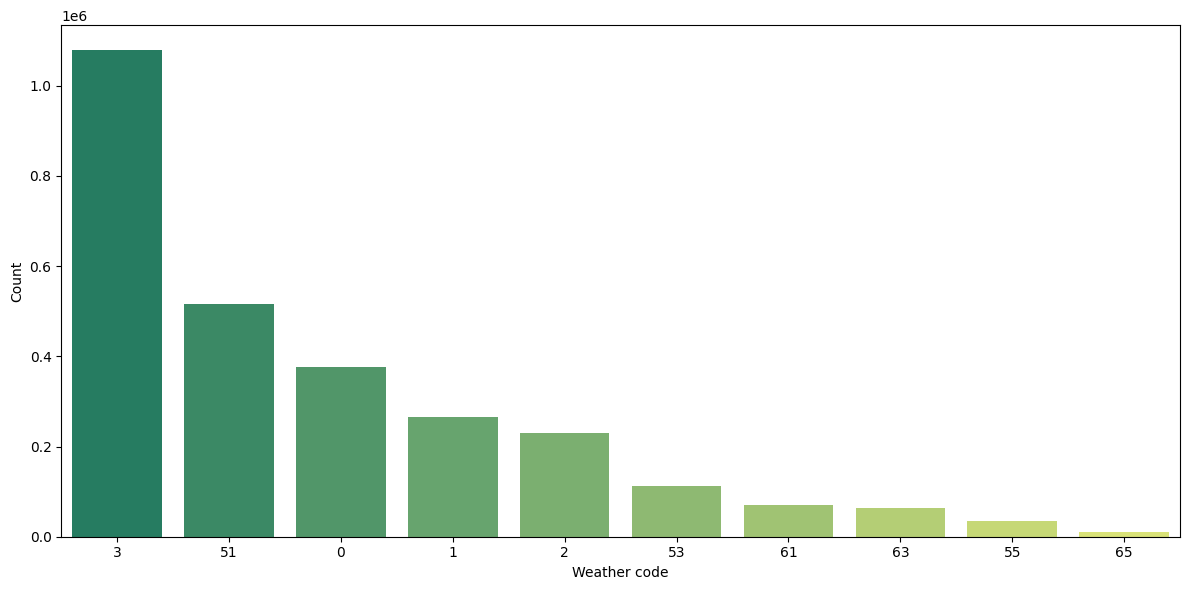

In [ ]:
plt.figure(figsize=(12, 6))

ax = sns.countplot(
    data=df,
    x='weather_code',
    palette='summer',
    order=df['weather_code'].value_counts().index
)

ax.set_xlabel('Weather code')
ax.set_ylabel('Count')
plt.xticks(rotation=0)

plt.tight_layout()
plt.show()
plt.close()

In [ ]:
df.weather_code.nunique()

10

In [ ]:
df.weather_code.value_counts()

,count
weather_code,
3,1080217
51,516792
0,376597
1,265263
2,230890
53,113287
61,71171
63,63714
55,34165


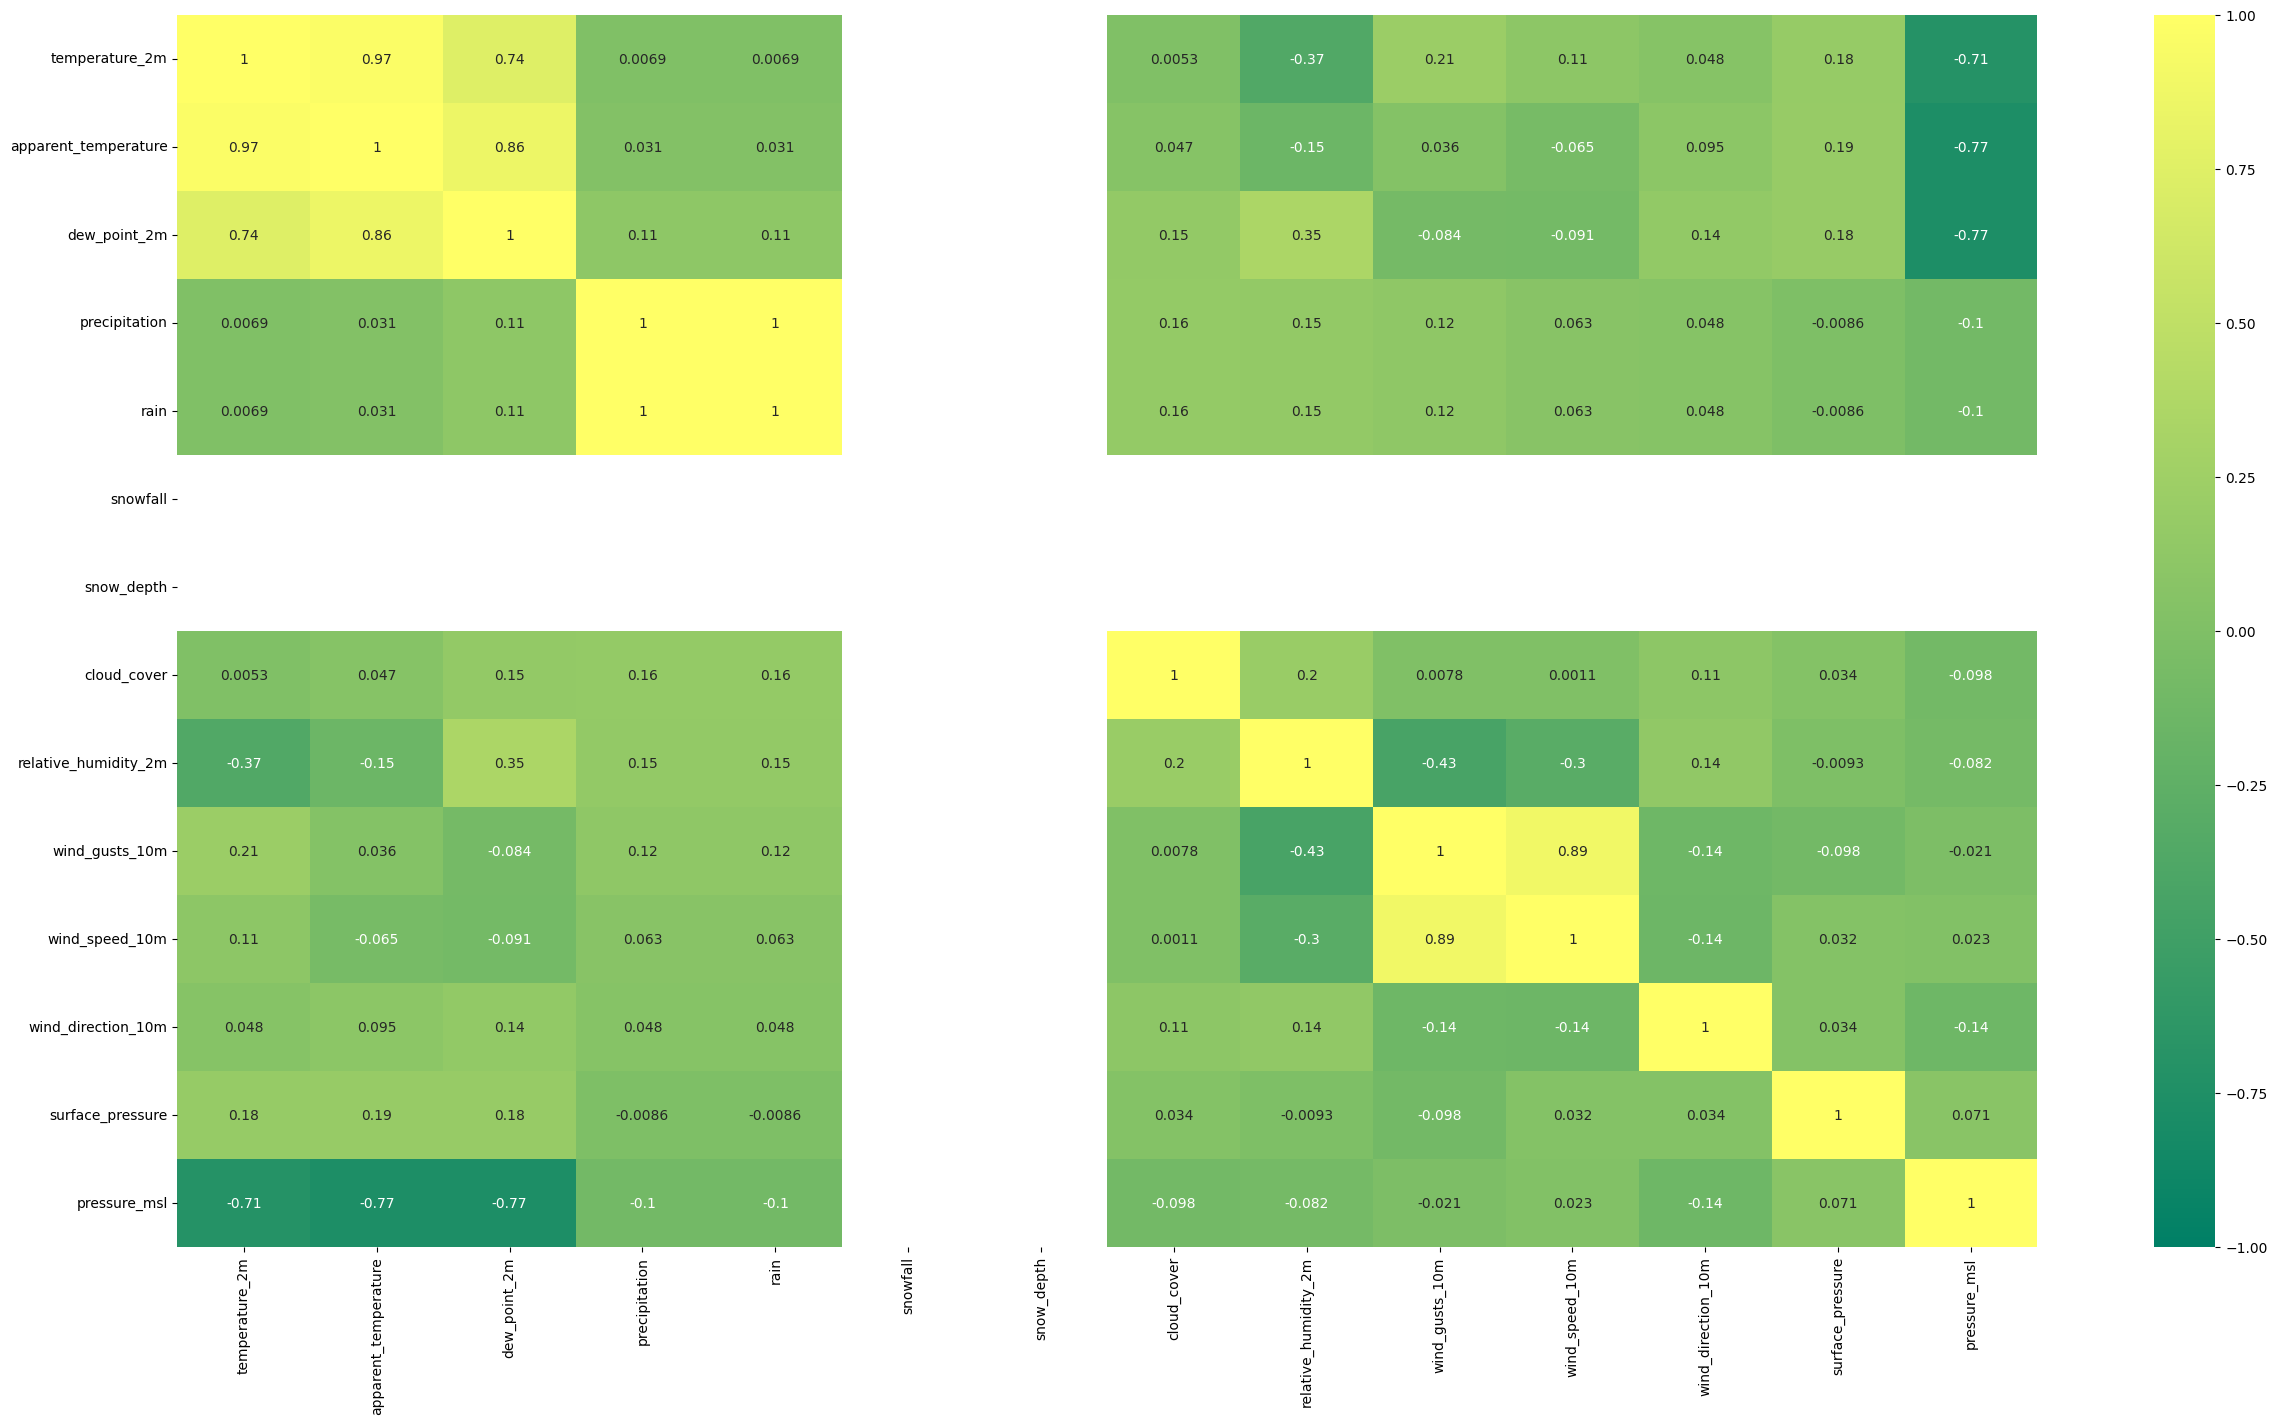

80933

In [ ]:
selected_columns = ['temperature_2m', 'apparent_temperature', 'dew_point_2m', 'precipitation', 'rain', 'snowfall', 'snow_depth',
                    'cloud_cover', 'relative_humidity_2m', 'wind_gusts_10m', 'wind_speed_10m', 'wind_direction_10m', 'surface_pressure', 'pressure_msl']

plt.figure(figsize=(30,16))
fig = sns.heatmap(df[selected_columns].corr(),annot=True,cmap='summer',vmin=-1.0,vmax=1.0)
plt.show(fig)
plt.close('all')
del fig
gc.collect()

In [ ]:
group1 = ['temperature_2m', 'apparent_temperature', 'dew_point_2m', 'cloud_cover', 'relative_humidity_2m']
group2 = ['precipitation', 'rain', 'snowfall', 'snow_depth']
group3 = ['wind_gusts_10m', 'wind_speed_10m', 'wind_direction_10m', 'surface_pressure', 'pressure_msl']

In [ ]:
codes = [0, 1, 2, 3, 51, 53, 55, 61, 63, 65]
df['weather_code'] = df['weather_code'].astype('category')
df['weather_code'] = df['weather_code'].cat.set_categories(codes)

In [ ]:
# for i, group in enumerate([group1, group2, group3], start=1):
#     sns.pairplot(
#         df[group + ['weather_code']],
#         hue='weather_code',
#         hue_order=codes,
#         palette='summer',
#         diag_kind='hist'
#     )
#     plt.suptitle(f"Pairplot for Group {i}", y=1.02)
#     plt.show()

## Feature Engineering

### Feature Extraction

In [ ]:
df['time'] = pd.to_datetime(df['time'], errors='coerce')

print(df['time'].dtype)          # datetime64[ns]
print(df['time'].isna().sum())   # 0

datetime64[ns]
0


In [ ]:
df['hour'] = df['time'].dt.hour
df['dayofyear'] = df['time'].dt.dayofyear

df['sin_hour'] = np.sin(2 * np.pi * df['hour'] / 24)
df['cos_hour'] = np.cos(2 * np.pi * df['hour'] / 24)

df['sin_doy'] = np.sin(2 * np.pi * df['dayofyear'] / 365)
df['cos_doy'] = np.cos(2 * np.pi * df['dayofyear'] / 365)

In [ ]:
df = df.drop(columns=['time', 'hour', 'dayofyear'])

### Outlier Treatment

In [ ]:
# skewed_cols = ['humidity']

# def remove_outliers(data,col):
#     lower_limit, upper_limit = data[col].quantile([0.25,0.75])
#     IQR = upper_limit - lower_limit
#     lower_whisker = lower_limit - 1.5 * IQR
#     upper_whisker = upper_limit + 1.5 * IQR
#     return np.where(data[col]<lower_whisker,lower_whisker,np.where(data[col]>upper_whisker,upper_whisker,data[col]))

In [ ]:
# for col in skewed_cols:
#     df[col] = remove_outliers(df,col)

In [ ]:
# fig = sns.boxplot(df['humidity'], palette='summer')
# plt.show(fig)
# plt.close('all')
# del fig
# gc.collect();

### Feature Splitting

In [ ]:
df.columns

Index(['temperature_2m', 'apparent_temperature', 'dew_point_2m',
       'precipitation', 'rain', 'snowfall', 'snow_depth', 'cloud_cover',
       'relative_humidity_2m', 'wind_gusts_10m', 'wind_speed_10m',
       'wind_direction_10m', 'surface_pressure', 'pressure_msl',
       'weather_code', 'sin_hour', 'cos_hour', 'sin_doy', 'cos_doy'],
      dtype='object')

In [ ]:
features = ['temperature_2m', 'apparent_temperature', 'dew_point_2m',
            'precipitation', 'rain', 'snowfall', 'snow_depth', 'cloud_cover',
            'relative_humidity_2m', 'wind_gusts_10m', 'wind_speed_10m',
            'wind_direction_10m', 'surface_pressure', 'pressure_msl',
            'sin_hour', 'cos_hour', 'sin_doy', 'cos_doy']

target_column = ['weather_code']

In [ ]:
X = df[features]
y = df[target_column]

### Balancing the target classes

In [ ]:
def oversample_to_min(X, y, label_value, min_size):
    mask = y['weather_code'] == label_value
    X_label = X[mask]
    y_label = y[mask]

    current_size = len(X_label)
    if current_size >= min_size:
        return X, y

    repeats = min_size // current_size + 1

    X_over = pd.concat([X_label] * repeats, ignore_index=True).iloc[:min_size]
    y_over = pd.concat([y_label] * repeats, ignore_index=True).iloc[:min_size]

    return (
        pd.concat([X, X_over], ignore_index=True),
        pd.concat([y, y_over], ignore_index=True)
    )

In [ ]:
X, y = oversample_to_min(X, y, 65, 50000)
X, y = oversample_to_min(X, y, 55, 80000)
X, y = oversample_to_min(X, y, 63, 100000)
X, y = oversample_to_min(X, y, 61, 110000)

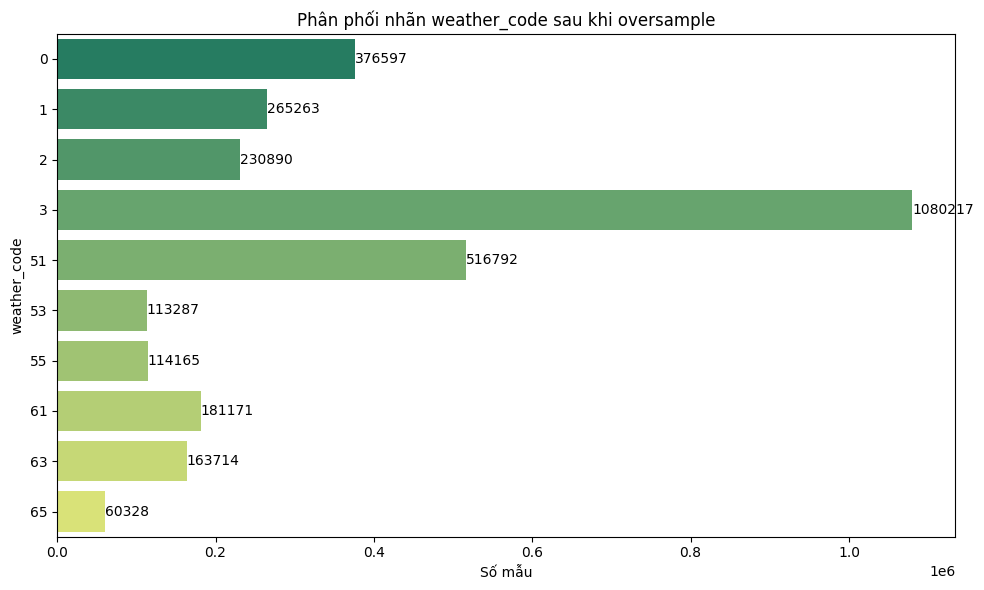

25094

In [ ]:
label_counts = y['weather_code'].value_counts().sort_index()

plt.figure(figsize=(10, 6))
ax = sns.barplot(
    x=label_counts.values,
    y=label_counts.index,
    palette="summer"
)

for i, v in enumerate(label_counts.values):
    ax.text(v + 50, i, v, va='center')

plt.xlabel("Số mẫu")
plt.title("Phân phối nhãn weather_code sau khi oversample")
plt.tight_layout()
plt.show()

plt.close("all")
gc.collect()


### Label Encoding

In [ ]:
encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y['weather_code'])

In [ ]:
encoder.classes_

array([ 0,  1,  2,  3, 51, 53, 55, 61, 63, 65])

In [ ]:
np.unique(y_encoded)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

### Train Test Split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded,
    test_size=0.2,
    random_state=42,
    shuffle=True,
    stratify=y_encoded
)

In [ ]:
print("Shape of the training set:",X_train.shape)
print("Shape of the testing set:",X_test.shape)

Shape of the training set: (2481939, 18)
Shape of the testing set: (620485, 18)


### Feature Selection

In [ ]:
pipeline = Pipeline([
    ('constant', DropConstantFeatures()),
    ('duplicate', DropDuplicateFeatures())
    # ('correlated', DropCorrelatedFeatures())
])

In [ ]:
X_train = pipeline.fit_transform(X_train)
X_test = pipeline.transform(X_test)

In [ ]:
print("Shape of the training set:",X_train.shape)
print("Shape of the testing set:",X_test.shape)

Shape of the training set: (2481939, 15)
Shape of the testing set: (620485, 15)


In [ ]:
print("Tên cột còn lại trong X_train:", X_train.columns.tolist())
print("Tên cột còn lại trong X_test:", X_test.columns.tolist())

Tên cột còn lại trong X_train: ['temperature_2m', 'apparent_temperature', 'dew_point_2m', 'precipitation', 'cloud_cover', 'relative_humidity_2m', 'wind_gusts_10m', 'wind_speed_10m', 'wind_direction_10m', 'surface_pressure', 'pressure_msl', 'sin_hour', 'cos_hour', 'sin_doy', 'cos_doy']
Tên cột còn lại trong X_test: ['temperature_2m', 'apparent_temperature', 'dew_point_2m', 'precipitation', 'cloud_cover', 'relative_humidity_2m', 'wind_gusts_10m', 'wind_speed_10m', 'wind_direction_10m', 'surface_pressure', 'pressure_msl', 'sin_hour', 'cos_hour', 'sin_doy', 'cos_doy']


In [ ]:
from sklearn.feature_selection import SelectKBest, f_classif

selector = SelectKBest(score_func=f_classif, k='all')
selector.fit(X_train, y_train)

scores = selector.scores_

score_df = pd.DataFrame({
    'feature': X_train.columns,
    'score': scores
}).sort_values('score', ascending=False)

top_10_features = score_df.head(10)['feature'].tolist()

print("Top 10 đặc trưng được chọn:", top_10_features)

Top 10 đặc trưng được chọn: ['cloud_cover', 'precipitation', 'relative_humidity_2m', 'dew_point_2m', 'sin_doy', 'wind_gusts_10m', 'cos_doy', 'cos_hour', 'pressure_msl', 'apparent_temperature']


In [ ]:
sfm = SelectFromModel(estimator=RandomForestClassifier(),max_features=10)
sfm.fit(X_train,y_train)

SelectFromModel(estimator=RandomForestClassifier(), max_features=10)

In [ ]:
selected_features = sfm.get_feature_names_out()
selected_features

array(['precipitation', 'cloud_cover'], dtype=object)

In [ ]:
xgb = XGBClassifier()
xgb.fit(X_train,y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, ...)

In [ ]:
def plot_feature_importances(feat_imp_type, figsize=(10, 8)):
    feat_imps = xgb.get_booster().get_score(importance_type=feat_imp_type)
    keys = list(feat_imps.keys())
    values = list(feat_imps.values())

    feat_imps_df = pd.DataFrame(data=values, index=keys, columns=["Importance"])\
        .sort_values(by="Importance", ascending=False).reset_index()
    feat_imps_df.rename({'index': 'Feature'}, axis=1, inplace=True)

    plt.figure(figsize=figsize)
    fig = sns.barplot(
        x='Importance',
        y='Feature',
        data=feat_imps_df,
        orient='h',
        palette='summer'
    )
    plt.title(f"{feat_imp_type.title()} Feature Importance", fontsize=16)
    plt.tight_layout()
    plt.show()
    plt.close('all')
    del fig
    gc.collect()


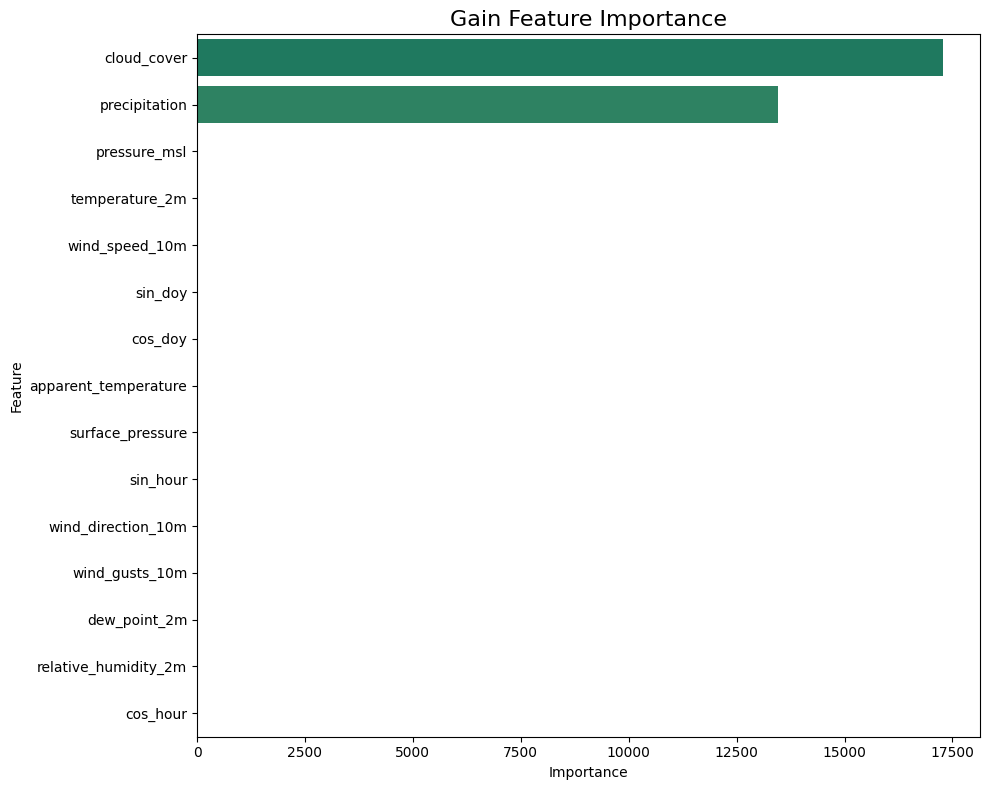

In [ ]:
plot_feature_importances('gain', figsize=(10, 8))

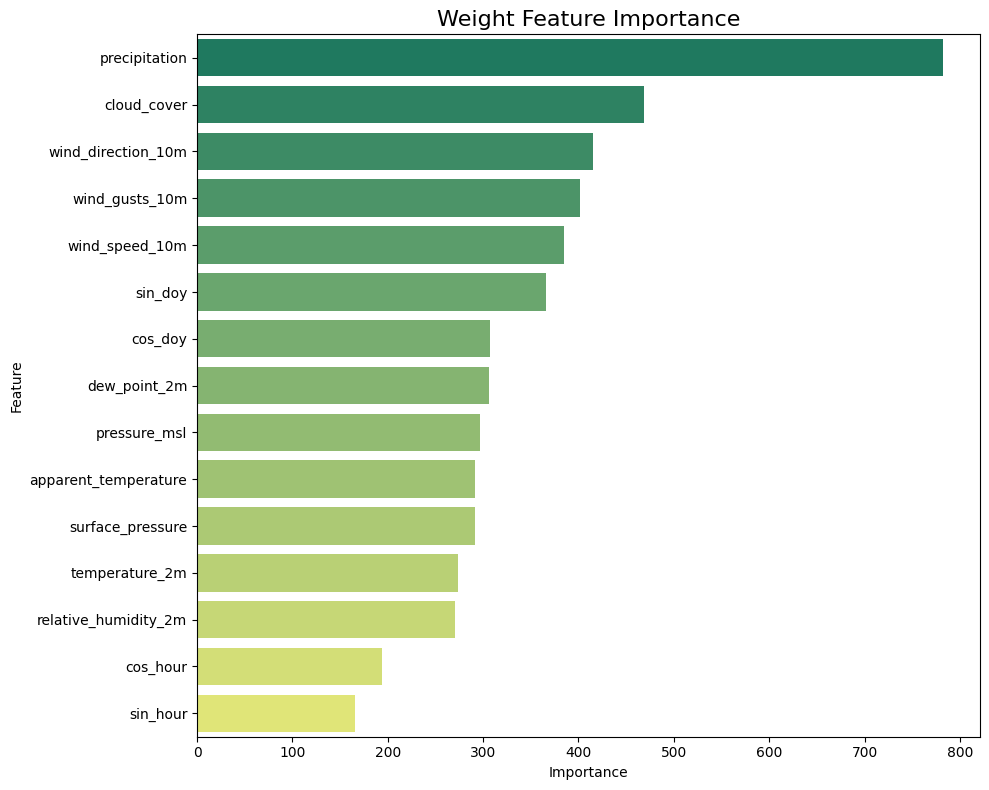

In [ ]:
plot_feature_importances('weight', figsize=(10, 8))

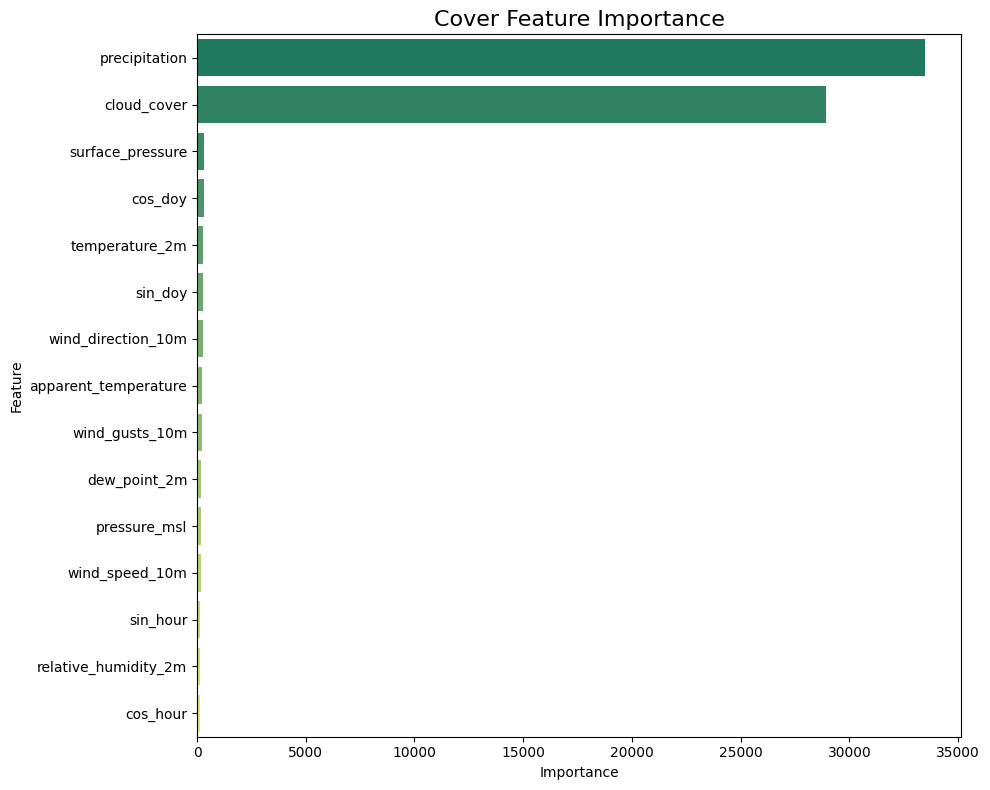

In [ ]:
plot_feature_importances('cover', figsize=(10, 8))

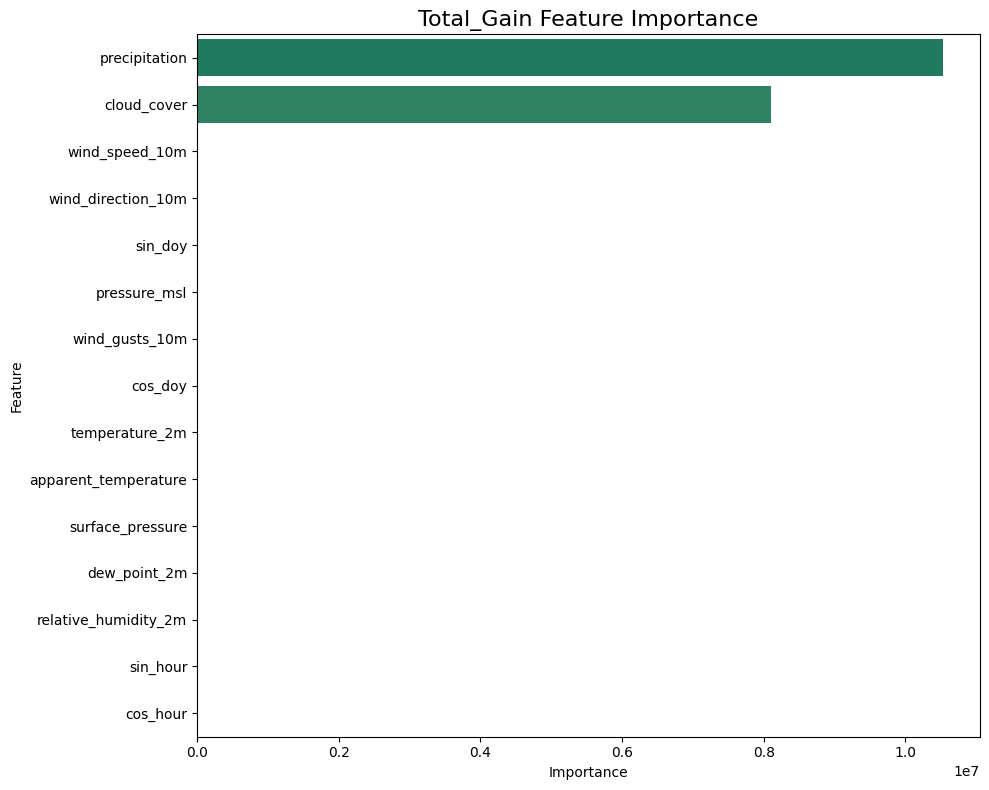

In [ ]:
plot_feature_importances('total_gain', figsize=(10, 8))

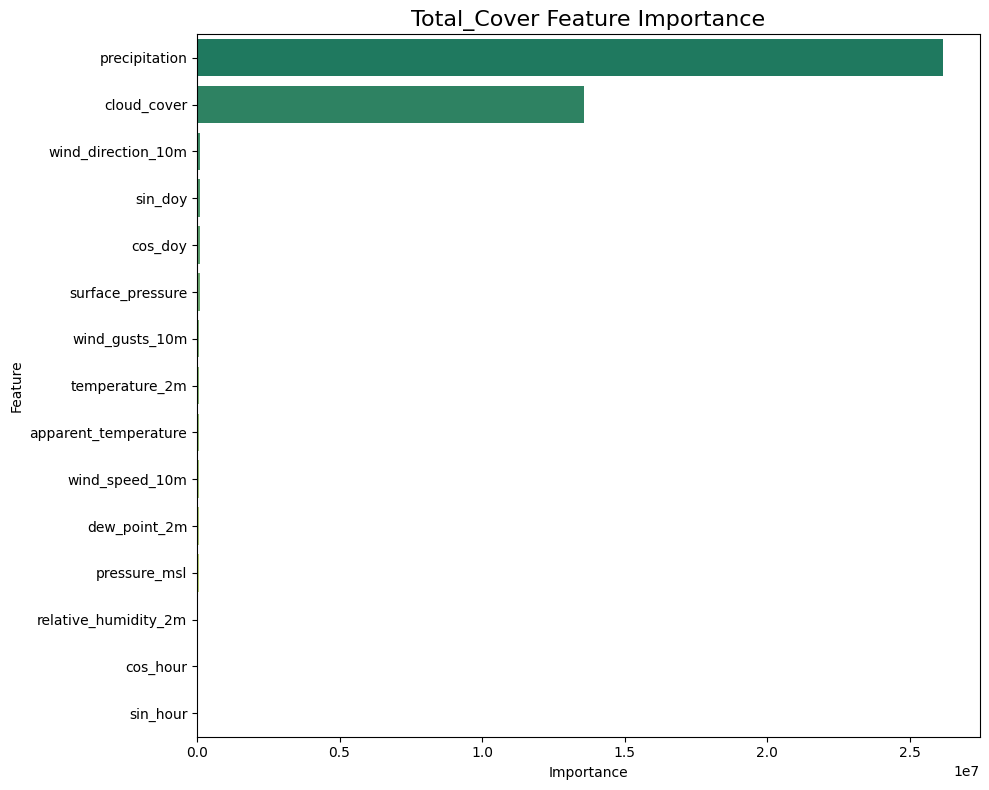

In [ ]:
plot_feature_importances('total_cover', figsize=(10, 8))

In [ ]:
final_selected_features = ['temperature_2m', 'apparent_temperature', 'dew_point_2m', 'precipitation', 'cloud_cover', 'relative_humidity_2m',
                            'wind_gusts_10m', 'wind_speed_10m', 'wind_direction_10m', 'surface_pressure', 'pressure_msl',
                            'sin_hour', 'cos_hour', 'sin_doy', 'cos_doy']

final_X_train = X_train[final_selected_features]
final_X_test = X_test[final_selected_features]

In [ ]:
gc.collect()

5461

### Feature Scaling

In [ ]:
scaler = StandardScaler()
features = final_X_train.columns
final_X_train = scaler.fit_transform(final_X_train)
final_X_train = pd.DataFrame(final_X_train,columns=features)
final_X_test = scaler.transform(final_X_test)
final_X_test = pd.DataFrame(final_X_test,columns=features)

final_X_train.head()

,temperature_2m,apparent_temperature,dew_point_2m,precipitation,cloud_cover,relative_humidity_2m,wind_gusts_10m,wind_speed_10m,wind_direction_10m,surface_pressure,pressure_msl,sin_hour,cos_hour,sin_doy,cos_doy
0,0.170131,0.567131,0.950481,-0.328416,0.672098,1.225028,-1.326687,-0.876787,0.363892,0.258225,-0.990777,1.441282,0.022125,-0.391184,-1.305214
1,0.277140,0.383376,0.684623,1.085174,0.701724,0.595536,0.503561,0.175780,0.292114,0.321474,-0.655506,-0.345928,-1.339258,-0.106753,-1.367720
2,0.662374,0.674321,0.551693,-0.328416,-2.260924,-0.243788,-0.799798,-0.332356,0.435671,0.294843,-0.785889,0.731406,1.242707,0.938674,-1.060859
3,0.234336,0.567131,0.773242,0.352201,0.701724,0.805367,-1.261982,-1.239742,2.004536,0.414684,-0.133972,-0.345928,1.383507,-0.226786,-1.348871
4,-0.193701,-0.045387,0.108596,-0.328416,0.523965,0.385705,-1.030890,-0.985674,0.158812,0.364750,-0.338860,0.731406,1.242707,-1.291926,0.481775


In [ ]:
dump(scaler, '/content/drive/MyDrive/DATN/source/model_hourly/scaler_hourly.joblib', compress=3)

dump(encoder, '/content/drive/MyDrive/DATN/source/model_hourly/label_encoder_hourly.joblib', compress=3)

['/content/drive/MyDrive/DATN/source/model_hourly/label_encoder_hourly.joblib']

## Model Training & Evaluation

In [ ]:
models = []
accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []
hamming_losses = []

In [ ]:
def train_and_evaluate_model(model):
    model.fit(final_X_train, y_train)
    y_pred = model.predict(final_X_test)

    print("Classification Report:")
    print(classification_report(y_test, y_pred, zero_division=0))
    print('-'*50)
    ConfusionMatrixDisplay.from_predictions(y_test,y_pred)

    acc = accuracy_score(y_test, y_pred)
    hamming = hamming_loss(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='macro', zero_division=0)
    recall = recall_score(y_test, y_pred, average='macro', zero_division=0)
    f1 = f1_score(y_test, y_pred, average='macro', zero_division=0)

    accuracy_scores.append(acc)
    hamming_losses.append(hamming)
    precision_scores.append(precision)
    recall_scores.append(recall)
    f1_scores.append(f1)
    models.append(model)
    gc.collect()

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99     75319
           1       0.98      0.98      0.98     53053
           2       0.98      0.99      0.98     46178
           3       1.00      1.00      1.00    216044
           4       1.00      0.99      1.00    103358
           5       1.00      1.00      1.00     22657
           6       1.00      1.00      1.00     22833
           7       1.00      1.00      1.00     36234
           8       1.00      1.00      1.00     32743
           9       0.99      1.00      1.00     12066

    accuracy                           0.99    620485
   macro avg       0.99      1.00      0.99    620485
weighted avg       0.99      0.99      0.99    620485

--------------------------------------------------


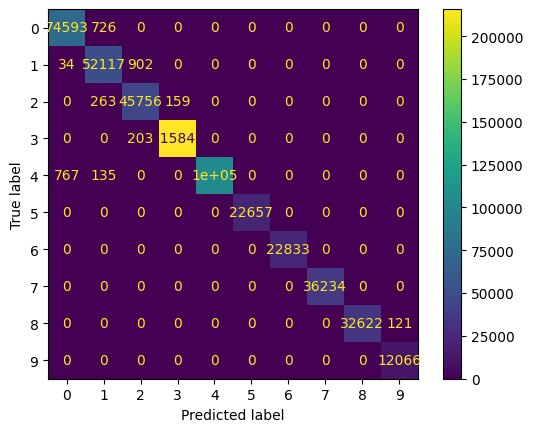

In [ ]:
lr = LogisticRegression(max_iter=1000)
train_and_evaluate_model(lr)

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     75319
           1       1.00      1.00      1.00     53053
           2       1.00      1.00      1.00     46178
           3       1.00      1.00      1.00    216044
           4       1.00      1.00      1.00    103358
           5       1.00      1.00      1.00     22657
           6       1.00      1.00      1.00     22833
           7       1.00      1.00      1.00     36234
           8       1.00      1.00      1.00     32743
           9       1.00      1.00      1.00     12066

    accuracy                           1.00    620485
   macro avg       1.00      1.00      1.00    620485
weighted avg       1.00      1.00      1.00    620485

--------------------------------------------------


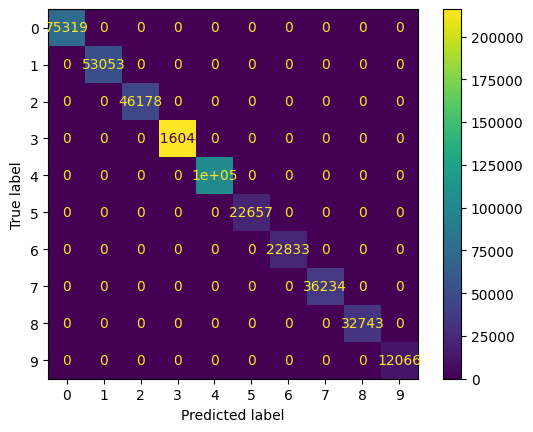

In [ ]:
dtc = DecisionTreeClassifier(random_state=42)
train_and_evaluate_model(dtc)

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     75319
           1       1.00      1.00      1.00     53053
           2       1.00      1.00      1.00     46178
           3       1.00      1.00      1.00    216044
           4       1.00      1.00      1.00    103358
           5       1.00      1.00      1.00     22657
           6       1.00      1.00      1.00     22833
           7       1.00      1.00      1.00     36234
           8       1.00      1.00      1.00     32743
           9       1.00      1.00      1.00     12066

    accuracy                           1.00    620485
   macro avg       1.00      1.00      1.00    620485
weighted avg       1.00      1.00      1.00    620485

--------------------------------------------------


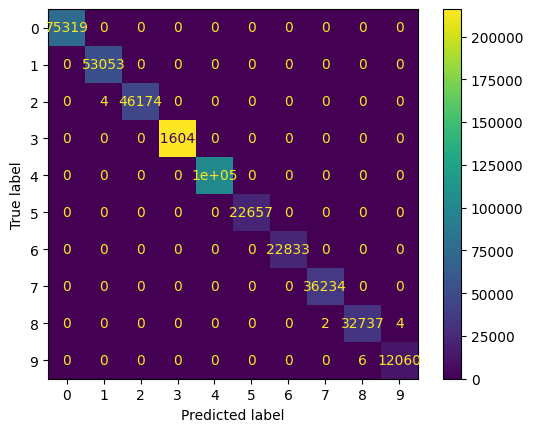

In [ ]:
rfc = RandomForestClassifier(random_state=42)
train_and_evaluate_model(rfc)

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     75319
           1       1.00      1.00      1.00     53053
           2       1.00      1.00      1.00     46178
           3       1.00      1.00      1.00    216044
           4       1.00      1.00      1.00    103358
           5       1.00      1.00      1.00     22657
           6       1.00      1.00      1.00     22833
           7       1.00      1.00      1.00     36234
           8       1.00      1.00      1.00     32743
           9       1.00      1.00      1.00     12066

    accuracy                           1.00    620485
   macro avg       1.00      1.00      1.00    620485
weighted avg       1.00      1.00      1.00    620485

--------------------------------------------------


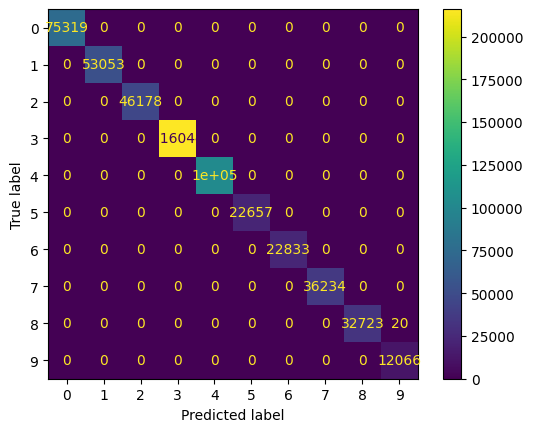

In [ ]:
hgbc = HistGradientBoostingClassifier()
train_and_evaluate_model(hgbc)

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     75319
           1       1.00      1.00      1.00     53053
           2       1.00      1.00      1.00     46178
           3       1.00      1.00      1.00    216044
           4       1.00      1.00      1.00    103358
           5       1.00      1.00      1.00     22657
           6       1.00      1.00      1.00     22833
           7       1.00      1.00      1.00     36234
           8       1.00      1.00      1.00     32743
           9       1.00      1.00      1.00     12066

    accuracy                           1.00    620485
   macro avg       1.00      1.00      1.00    620485
weighted avg       1.00      1.00      1.00    620485

--------------------------------------------------


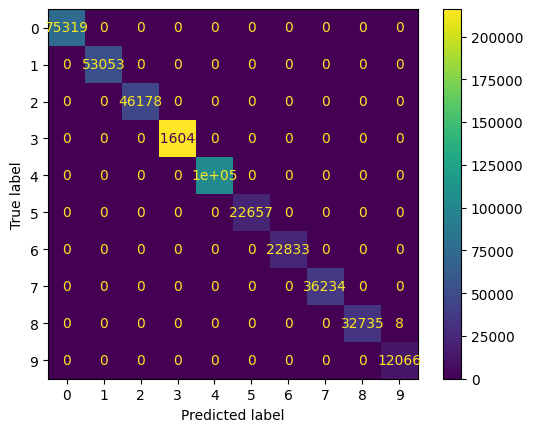

In [ ]:
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
train_and_evaluate_model(xgb)

## Baseline Models Performance Comparison

In [ ]:
model_perfs = pd.DataFrame({'Model': models,
                            'Accuracy': accuracy_scores,
                            'Precision': precision_scores,
                            'Recall': recall_scores,
                            'F1': f1_scores}).sort_values('Accuracy',ascending=False)
model_perfs

,Model,Accuracy,Precision,Recall,F1
1,DecisionTreeClassifier(random_state=42),1.000000,1.000000,1.000000,1.000000
4,"XGBClassifier(base_score=None, booster=None, c...",0.999987,0.999934,0.999976,0.999955
2,"(DecisionTreeClassifier(max_features=3, random...",0.999974,0.999935,0.999923,0.999929
3,HistGradientBoostingClassifier(),0.999968,0.999835,0.999939,0.999887
0,LogisticRegression(max_iter=1000),0.994665,0.993402,0.995022,0.994201


## Hyperparameter Tuning and Cross Validation


In [ ]:
param_distributions = {
    'learning_rate': [0.05, 0.1],
    'max_depth': [6, 8],
    'max_iter': [150, 250],
    'min_samples_leaf': [50, 100],
    'l2_regularization': [0.0, 0.1]
}

base_hgb = HistGradientBoostingClassifier(
    random_state=42,
    class_weight='balanced',
    early_stopping=False
)

search_hgb = RandomizedSearchCV(
    estimator=base_hgb,
    param_distributions=param_distributions,
    n_iter=5,
    scoring='f1_macro',
    cv=3,
    verbose=2,
    n_jobs=1,
    random_state=42
)

search_hgb.fit(final_X_train, y_train)

Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] END l2_regularization=0.1, learning_rate=0.1, max_depth=8, max_iter=150, min_samples_leaf=100; total time= 5.3min
[CV] END l2_regularization=0.1, learning_rate=0.1, max_depth=8, max_iter=150, min_samples_leaf=100; total time= 5.2min
[CV] END l2_regularization=0.1, learning_rate=0.1, max_depth=8, max_iter=150, min_samples_leaf=100; total time= 5.1min
[CV] END l2_regularization=0.0, learning_rate=0.1, max_depth=8, max_iter=250, min_samples_leaf=100; total time= 8.9min
[CV] END l2_regularization=0.0, learning_rate=0.1, max_depth=8, max_iter=250, min_samples_leaf=100; total time= 8.2min
[CV] END l2_regularization=0.0, learning_rate=0.1, max_depth=8, max_iter=250, min_samples_leaf=100; total time= 8.6min
[CV] END l2_regularization=0.1, learning_rate=0.1, max_depth=6, max_iter=150, min_samples_leaf=50; total time= 5.4min
[CV] END l2_regularization=0.1, learning_rate=0.1, max_depth=6, max_iter=150, min_samples_leaf=50; total tim

RandomizedSearchCV(cv=3,
                   estimator=HistGradientBoostingClassifier(class_weight='balanced',
                                                            early_stopping=False,
                                                            random_state=42),
                   n_iter=5, n_jobs=1,
                   param_distributions={'l2_regularization': [0.0, 0.1],
                                        'learning_rate': [0.05, 0.1],
                                        'max_depth': [6, 8],
                                        'max_iter': [150, 250],
                                        'min_samples_leaf': [50, 100]},
                   random_state=42, scoring='f1_macro', verbose=2)

In [ ]:
search_hgb.best_score_

np.float64(0.9991455084621957)

In [ ]:
best_hgb = search_hgb.best_estimator_
print("Best params:", search_hgb.best_params_)

In [ ]:
y_pred = best_hgb.predict(final_X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     75319
           1       1.00      1.00      1.00     53053
           2       1.00      1.00      1.00     46178
           3       1.00      1.00      1.00    216044
           4       1.00      1.00      1.00    103358
           5       1.00      1.00      1.00     22657
           6       1.00      1.00      1.00     22833
           7       1.00      1.00      1.00     36234
           8       1.00      1.00      1.00     32743
           9       1.00      1.00      1.00     12066

    accuracy                           1.00    620485
   macro avg       1.00      1.00      1.00    620485
weighted avg       1.00      1.00      1.00    620485



## Deep Learning Model Training & Evaluation

In [ ]:
model = Sequential()
model.add(Dense(64, activation='relu', input_dim=final_X_train.shape[1]))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(10, activation='softmax'))  # 10 nhãn

model.compile(
    optimizer=Adam(learning_rate=1e-3),
    loss='sparse_categorical_crossentropy',  # nếu y là số 0–9
    metrics=['accuracy']
)

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 27,146 (106.04 KB)

 Trainable params: 27,146 (106.04 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
rl = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=10,
    min_lr=1e-5,
    verbose=1
)

mc = ModelCheckpoint(
    'model.keras',
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

es = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

# Train model
r = model.fit(
    final_X_train,
    y_train,
    batch_size=32,
    epochs=50,
    callbacks=[es, rl, mc],
    validation_data=(final_X_test, y_test),
    verbose=1
)

Epoch 1/50
77559/77561 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9998 - loss: 0.0032
Epoch 1: val_loss improved from inf to 0.00001, saving model to model.keras
77561/77561 ━━━━━━━━━━━━━━━━━━━━ 292s 4ms/step - accuracy: 0.9998 - loss: 0.0032 - val_accuracy: 1.0000 - val_loss: 9.2135e-06 - learning_rate: 1.0000e-05
Epoch 2/50
77558/77561 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9998 - loss: 0.0026
Epoch 2: val_loss did not improve from 0.00001
77561/77561 ━━━━━━━━━━━━━━━━━━━━ 283s 4ms/step - accuracy: 0.9998 - loss: 0.0026 - val_accuracy: 1.0000 - val_loss: 2.3023e-05 - learning_rate: 1.0000e-05
Epoch 3/50
77552/77561 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9998 - loss: 0.0017
Epoch 3: val_loss improved from 0.00001 to 0.00001, saving model to model.keras
77561/77561 ━━━━━━━━━━━━━━━━━━━━ 291s 4ms/step - accuracy: 0.9998 - loss: 0.0017 - val_accuracy: 1.0000 - val_loss: 9.0098e-06 - learning_rate: 1.0000e-05
Epoch 4/50
77556/77561 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accu

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# ----- Loss -----
axes[0].plot(r.history['loss'], label='Train Loss')
axes[0].plot(r.history['val_loss'], label='Validation Loss')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training vs Validation Loss')
axes[0].legend()
axes[0].grid(alpha=0.3)

# ----- Accuracy -----
axes[1].plot(r.history['accuracy'], label='Train Accuracy')
axes[1].plot(r.history['val_accuracy'], label='Validation Accuracy')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Training vs Validation Accuracy')
axes[1].set_ylim(0, 1)
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

In [ ]:
# Dự đoán xác suất
y_pred_proba = model.predict(final_X_test)

# Lấy nhãn dự đoán
y_pred_dl = np.argmax(y_pred_proba, axis=1)

# Tính chỉ số
acc_dl = accuracy_score(y_test, y_pred_dl)
precision_dl = precision_score(y_test, y_pred_dl, average='macro', zero_division=0)
recall_dl = recall_score(y_test, y_pred_dl, average='macro', zero_division=0)
f1_dl = f1_score(y_test, y_pred_dl, average='macro', zero_division=0)

In [ ]:
# Thêm Deep Learning model và các chỉ số vào danh sách
models.append('Deep Learning')
accuracy_scores.append(acc_dl)
precision_scores.append(precision_dl)
recall_scores.append(recall_dl)
f1_scores.append(f1_dl)

In [ ]:
# 1. Thêm model mới (vẫn giữ index = 16)
new_index = model_perfs.index.max() + 1
new_row = pd.DataFrame({
    'Model': ['Deep Learning'],
    'Accuracy': [acc_dl],
    'Precision': [precision_dl],
    'Recall': [recall_dl],
    'F1': [f1_dl]
}, index=[new_index])

model_perfs = pd.concat([model_perfs, new_row])

# 2. Tạo DataFrame hiển thị (không đụng gì đến index)
display_df = model_perfs.copy()

# 3. Sắp xếp theo Accuracy (index giữ nguyên)
display_df = display_df.sort_values(by='Accuracy', ascending=False)

# 4. Tạo cột STT từ 0 đến N để hiển thị
display_df.insert(0, 'STT', range(1, len(display_df) + 1))  # bắt đầu từ 1 nếu muốn

display_df

In [ ]:
best_model = models[3]
best_model

## Saving the best performing model for deployment into production

In [ ]:
dump(best_model, '/content/drive/MyDrive/DATN/source/model_hourly/hgbC.joblib', compress=1)

['/content/drive/MyDrive/DATN/source/model_daily/votingC.joblib']

In [ ]:
gc.collect()

12354

### 1. Data Preparation Function

This function will perform the same feature engineering and scaling steps that were applied to the training data. It will ensure that your new input data is in the correct format for the model.

In [1]:
from joblib import load

# Load the saved scaler and label encoder
loaded_scaler = load('/content/scaler_hourly.joblib')
loaded_encoder = load('/content/label_encoder_hourly.joblib')
loaded_model = load('/content/hgbC.joblib')
# Define the final selected features (must match the training set)
final_selected_features = [
    'temperature_2m', 'apparent_temperature', 'dew_point_2m', 'precipitation',
    'cloud_cover', 'relative_humidity_2m', 'wind_gusts_10m', 'wind_speed_10m',
    'wind_direction_10m', 'surface_pressure', 'pressure_msl',
    'sin_hour', 'cos_hour', 'sin_doy', 'cos_doy'
]

def prepare_input_data(df_input):
    # Ensure 'time' column is datetime
    df_input['time'] = pd.to_datetime(df_input['time'], errors='coerce')

    # Extract time-based features
    df_input['hour'] = df_input['time'].dt.hour
    df_input['dayofyear'] = df_input['time'].dt.dayofyear

    df_input['sin_hour'] = np.sin(2 * np.pi * df_input['hour'] / 24)
    df_input['cos_hour'] = np.cos(2 * np.pi * df_input['hour'] / 24)

    df_input['sin_doy'] = np.sin(2 * np.pi * df_input['dayofyear'] / 365)
    df_input['cos_doy'] = np.cos(2 * np.pi * df_input['dayofyear'] / 365)

    # Select only the features used for training
    processed_df = df_input[final_selected_features]

    # Apply the same scaling used during training
    scaled_data = loaded_scaler.transform(processed_df)
    scaled_df = pd.DataFrame(scaled_data, columns=final_selected_features)

    return scaled_df

print("Data preparation function defined.")


Data preparation function defined.


### 2. Prediction Function

This function loads the trained HistGradientBoostingClassifier model, takes the prepared data, makes predictions, and converts the encoded labels back to original weather codes.

In [2]:
# Load the trained model


def predict_weather_code(prepared_data):
    # Make predictions
    predictions_encoded = loaded_model.predict(prepared_data)

    # Inverse transform the predictions to get original weather codes
    predictions_original = loaded_encoder.inverse_transform(predictions_encoded)

    return predictions_original

print("Prediction function defined.")


Prediction function defined.


### 3. Example Usage

Let's create a sample DataFrame with new weather data and use the functions to predict the `weather_code`.

In [3]:
import pandas as pd
import numpy as np

# Create sample input data (ensure column names match original data before feature engineering)
sample_data = pd.DataFrame({
    'time': ['2024-07-26T10:00', '2024-07-26T11:00', '2024-07-26T12:00'],
    'temperature_2m': [25.0, 26.5, 27.0],
    'apparent_temperature': [28.0, 29.5, 30.0],
    'dew_point_2m': [20.0, 21.0, 21.5],
    'precipitation': [0.1, 0.0, 0.0],
    'rain': [0.1, 0.0, 0.0],
    'snowfall': [0.0, 0.0, 0.0],
    'snow_depth': [0.0, 0.0, 0.0],
    'cloud_cover': [70, 60, 50],
    'relative_humidity_2m': [85, 80, 75],
    'wind_gusts_10m': [15.0, 18.0, 20.0],
    'wind_speed_10m': [8.0, 10.0, 12.0],
    'wind_direction_10m': [180, 190, 200],
    'surface_pressure': [1010.0, 1009.5, 1009.0],
    'pressure_msl': [1012.0, 1011.5, 1011.0]
})

# Prepare the sample data
prepared_sample_data = prepare_input_data(sample_data.copy())

# Make predictions
predicted_weather_codes = predict_weather_code(prepared_sample_data)

print("Predicted Weather Codes:")
print(predicted_weather_codes)

# You can also add the predictions back to your original sample data for context
sample_data['predicted_weather_code'] = predicted_weather_codes
display(sample_data)


Predicted Weather Codes:
[51  2  2]


,time,temperature_2m,apparent_temperature,dew_point_2m,precipitation,rain,snowfall,snow_depth,cloud_cover,relative_humidity_2m,wind_gusts_10m,wind_speed_10m,wind_direction_10m,surface_pressure,pressure_msl,predicted_weather_code
0,2024-07-26T10:00,25.0,28.0,20.0,0.1,0.1,0.0,0.0,70,85,15.0,8.0,180,1010.0,1012.0,51
1,2024-07-26T11:00,26.5,29.5,21.0,0.0,0.0,0.0,0.0,60,80,18.0,10.0,190,1009.5,1011.5,2
2,2024-07-26T12:00,27.0,30.0,21.5,0.0,0.0,0.0,0.0,50,75,20.0,12.0,200,1009.0,1011.0,2
